# Wind Tunnel Data

An airframe was mounted in the University of Bristol's 7'x5' wind tunnel. An
[ATI mini45](https://www.ati-ia.com/products/ft/ft_models.aspx?id=mini45) load cell was mounted within the airframe.
This was attached to the pitch traverse of the existing load cell.

Automated control inputs were generated by a set of Python scripts which also automatically recorded load cell data.
The raw wind tunnel data is available in [`wind_tunnel_data/raw`](./wind_tunnel_data/raw). Some notes on
this data can also be found in the folder.

Some pre-processed data can be found in the [`wind_tunnel_data/processed`](./wind_tunnel_data/processed)
folder. They are saved as Python pickle files. The pickle files are named with the convention
`data_{day}_{airspeed}.pkl`. They have been processed using the processing scripts in
[`processing_scripts`](./processing_scripts). The following operations have been performed:
- Load cell tares have been applied
- Axes aligned with aerospace conventions
- Moments recomputed about vehicle reference point (0.015m fwd, 0.023m up)
- Control surface angles calculated
- Lift and drag values calculated

> NB: The paths in the processing scripts will likely need correcting.

# Aircraft Parameters

Parameter     | Symbol | Value     | Unit
--------------|--------|-----------|------------
Wing Chord    | $c$    | $0.23$    | $\mathrm{m}$
Wing Area     | $S$    | $0.2625$  | $\mathrm{m}^2$
Tail Area     | $S_T$  | $0.08251$ | $\mathrm{m}^2$
Tail offset   | $x_T$  | $0.5533$  | $\mathrm{m}$
Prop diameter | $D$    | $0.2794$  | $\mathrm{m}$

# Initial Fits

There are a couple of functions that have been used to construct the fits, the most basic is the Heaviside
approximation, denoted $H$:

$$
H(x,p,k) = \frac{1}{1 + e^{-2k(x-p)}}
$$

This is approximately $0$ for all $x << p$, and approximately $1$ for all $x >> p$. Around $p$, there is a smooth
transition between the values. As $k \rightarrow \infty$, the function approaches the true Heaviside function about $p$.
If not otherwise specified $k = 10$.

The "heavicentre" function $S$ is approximately $1$ within some range and rolls off to $0$ at the edges. It is defined
as:

$$
S(x,l,h,k) = H(x,l,k) (1-H(x,h,k))
$$

As with the Heaviside approximation, if not otherwise specified, $k = 10$

All parameter values are fitted for $\alpha$ and all other angles in radians.

### $C_L$

The $C_L$ fit is defined as:

$$
C_L(\alpha) = S(\alpha,\alpha_{nstall},\alpha_{pstall}) (C_{L0} + C_{L_{\alpha}} \alpha)
$$

This is a linear fit in the centre of the range with a asymptote at $0$ beyond the positive and negative stall angles.
Parameters to fit are: $C_{L0}$, $C_{L_{\alpha}}$, $\alpha_{pstall}$ and $\alpha_{nstall}$

### $C_D$

The $C_D$ fit is defined as:

$$
C_D(\alpha) = S(\alpha,-\alpha_{lim},\alpha_{lim}) (C_{D_{\alpha}} (\alpha - \alpha_{C_{D0}})^2 + C_{D0} )
            + 2 (1-S(\alpha,-\alpha_{lim},\alpha_{lim}))
$$

This is a quadratic fit in the centre of the range with a asymptote at $2$ beyond $\alpha_{lim}$.
Parameters to fit are: $C_{D0}$, $C_{D_{\alpha}}$ and $\alpha_{C_{D0}}$.

### $C_M$

The $C_M$ fit is defined as:

$$
C_M(\alpha) = S(\alpha,-\alpha_{lim},\alpha_{lim},12) (v \tan(h(\alpha-\alpha_{C_{M0}})) + C_{M0})
        +  0.5 (1.0-H(\alpha,-\alpha_{lim},12))
        -0.5 H(\alpha,\alpha_{lim},12)
$$

This is a $\tan$-based fit in the centre of the range, with asymptotes to $0.5$ and $-0.5$ on the negative and positive
ranges respectively. Note that for $S(\cdot)$ and $H(\cdot)$, $k = 12$. For the $C_M$ fit, $\alpha_{lim} = 15\degree$.
Parameters to fit are: $C_{M0}$, $\alpha_{C_{M0}}$, $h$ and $v$.

The fitted parameters for all three curves are printed at the bottom of the code block below. These are in the order
defined in the text above, reproduced below for clarity:

Curve | Parameters
------|------------------------
$C_L$ | $C_{L0}$, $C_{L_{\alpha}}$, $\alpha_{pstall}$ and $\alpha_{nstall}$
$C_D$ | $C_{D0}$, $C_{D_{\alpha}}$ and $\alpha_{C_{D0}}$
$C_M$ | $C_{M0}$, $\alpha_{C_{M0}}$, $h$ and $v$


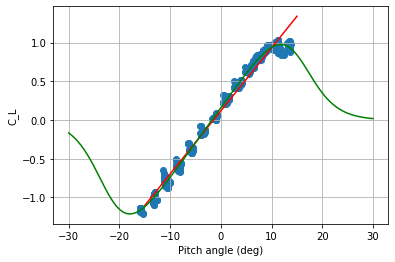

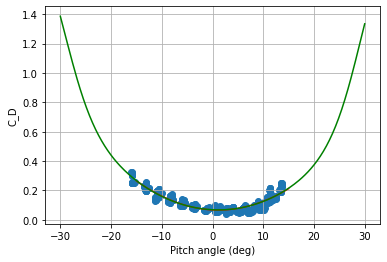

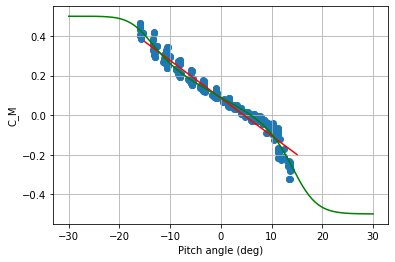

C_lift parameters: [ 0.16146493  5.22123182  0.27192924 -0.38997521]
C_drag parameters: [0.06712609 2.38136262 0.02072577]
C_M parameters: [ 0.0529582   0.04838408  1.41514536 -0.5462109 ]


In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt

import processing_scripts.utils as utils

import analysis_scripts.big3 as big3_analysis

data = big3_analysis.load_data()

neutral_data = utils.select_neutral(data)

c_lifts,C_lift,C_lift_complex = big3_analysis.calculate_C_lift(neutral_data)
c_ds,C_drag,C_drag_complex = big3_analysis.calculate_C_drag(neutral_data)
c_ms,C_M,C_M_complex = big3_analysis.calculate_C_M(neutral_data)

big3_analysis.make_top3_plots(neutral_data,
    c_lifts,C_lift,C_lift_complex,
    c_ds,C_drag,C_drag_complex,
    c_ms,C_M,C_M_complex
    )

plt.show()
print(f"C_lift parameters: {C_lift_complex}")
print(f"C_drag parameters: {C_drag_complex}")
print(f"C_M parameters: {C_M_complex}")

# Thrust Modelling

Thrust data is obtained from the zero-deflection data points throughout the overall dataset. Note that this does not
necessarily reflect the zero-trim condition.

First, the drag and lift cofficients at each data point are calculated according to the fits above. These are then
resolved into the body frame to calculate the expected $x$-axis load.

$$
F_{x,\mathrm{expect}} = -D \cos(\theta) + L \cos(\theta)
$$

$$
T = F_{x,\mathrm{meas}} - F_{x,\mathrm{expect}}
$$

Data at pitch angles exceeding $~10\degree$ appears to show significant distortion. This is likely due to interaction of
the rig and the model. Only data with a pitch of less than $2\degree$ is used in generating the thrust model. Data with
throttle set to 0.2 was also seen to be noisy. It is likely that the propeller was primarily driven by the airflow at
these low throttle settings. Therefore, only throttle settings above 0.2 are used to generate the data.

Thrust is modelled as a quadratic surface with respect to airspeed and throttle.

$$
T = a_0 V_\infty^2 + a_1 V_\infty \tau + a_2 \tau^2 + a_3 V_\infty + a_4 \tau + a_5
$$

a = [ 1.15762215e+01 -4.80418011e-01 -1.18219772e-02  1.34898220e+01
  4.65183954e-01 -4.10897993e+00]


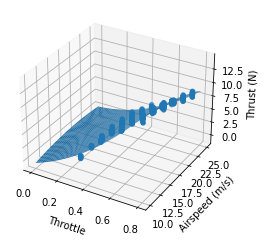

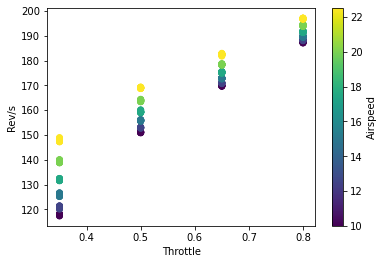

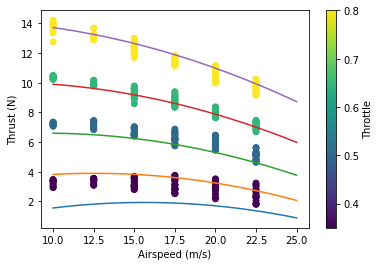

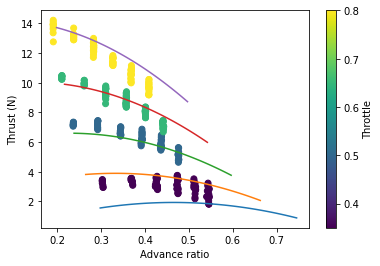

In [2]:
import analysis_scripts.thrust as thrust_analysis

from processing_scripts.utils.fits import Fit

c_lift_fit = Fit(big3_analysis.c_l_curve,C_lift_complex)
c_drag_fit = Fit(big3_analysis.c_d_curve,C_drag_complex)

thrust_analysis.calculate_plot_throttle(data,c_lift_fit,c_drag_fit)